### Computing PAI with resampling methods:

#### In Linear Regression:

In [1]:
import numpy as np
import pandas as pd

Old Data 

In [2]:
np.random.seed(123)

# Quantitative Response

Y_old = np.random.normal(loc=50, scale=10, size=500)

# Quantitative variables 

X1_old = np.random.normal(loc=30, scale=25, size=500)
 
# Binary variables 

X2_old = np.random.uniform(low=0.0, high=1.0, size=500).round()
 
# Multiclass categorical variables

X3_old = np.random.uniform(low=0, high=4, size=500).round()   # categories: 0,1,2,3,4
 

New Data (with a big change in X1 distribution)

In [3]:
np.random.seed(666)

# Quantitative Response

Y_new = np.random.normal(loc=50, scale=10, size=500)

# Quantitative variables 

X1_new = np.random.normal(loc=15, scale=60, size=500)
 
# Binary variables 

X2_new = np.random.uniform(low=0.0, high=1.0, size=500).round()
 
# Multiclass categorical variables

X3_new = np.random.uniform(low=0, high=4, size=500).round()   # categories: 0,1,2,3,4

In [4]:
df_Old = pd.DataFrame( {"Y":Y_old , "X1": X1_old , "X2": X2_old , "X3": X3_old} ) 

df_New = pd.DataFrame( {"Y":Y_new , "X1": X1_new , "X2": X2_new , "X3": X3_new} ) 

In [7]:
from plotnine import ggplot, aes, geom_line, geom_point, geom_histogram, geom_bar, geom_boxplot, scale_y_continuous, scale_x_continuous, labs, after_stat,  geom_vline, scale_color_manual, theme_gray, theme_xkcd, scale_color_identity, geom_hline, facet_wrap, scale_fill_discrete, scale_fill_manual,  scale_fill_hue, guides, guide_legend, ggtitle
from mizani.formatters import percent_format 

In [5]:
import array as arr

df_Old_New = pd.concat([df_Old , df_New])

repeat_Old = ['Old Data']*len(df_Old)

repeat_New = ['New Dta']*len(df_New)

df_repeat_New = pd.DataFrame( {"group": repeat_New} ) 

df_repeat_Old = pd.DataFrame( {"group": repeat_Old} ) 

groups = pd.concat([df_repeat_Old , df_repeat_New])

df_Old_New_groups = pd.concat([df_Old_New , groups], axis=1 ) 

df_Old_New_groups

,Y,X1,X2,X3,group
0,39.143694,48.800842,1.0,1.0,Old Data
1,59.973454,31.741019,0.0,3.0,Old Data
2,52.829785,23.363859,0.0,4.0,Old Data
3,34.937053,53.239612,1.0,1.0,Old Data
4,44.213997,61.520532,1.0,3.0,Old Data
...,...,...,...,...,...
495,56.756956,12.495333,0.0,3.0,New Dta
496,36.846327,75.862895,1.0,1.0,New Dta
497,36.528625,-21.430239,0.0,0.0,New Dta
498,62.143112,-56.088634,0.0,2.0,New Dta


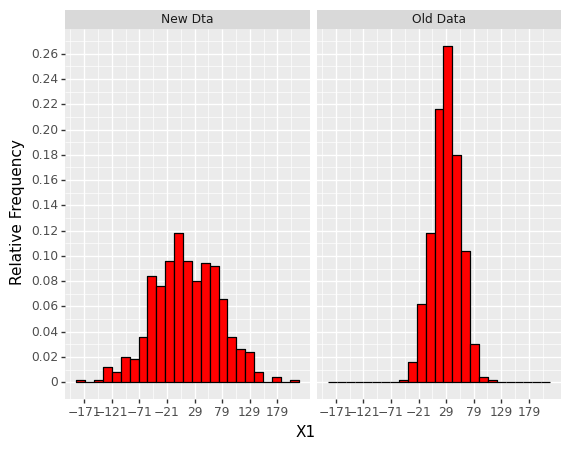

<ggplot: (144229958650)>

In [15]:
(
ggplot( df_Old_New_groups )
+  aes(x='X1' , y =  after_stat('width*density'))
+ geom_histogram(fill="red", color="black", bins = 25)
+  labs(x = "X1", y = "Relative Frequency")
+ scale_x_continuous( breaks = range(int(df_Old_New_groups['X1'].min()) , int(df_Old_New_groups['X1'].max()) , 50) ) 
+ scale_y_continuous( breaks = np.arange(0, 0.5, 0.02) )
+ facet_wrap('group')
)

We are going to consider the following definition of PAI (instead of use the variance, we will use the standard deviation. if we would consider the PAI definition with the variance, the process to compute it would have been very similar)

Where:

The numerator is computing by resampling methods using the model trained with the Old Data (for the response and the predictors) but predicting the response variable using the New Data for the predictors.

The denominator is computing by resampling methods using the model trained Old Data (for the response and the predictors) and also predicting the response variable using the Old Data for the predictors.

$$ 

PAI = \dfrac{\dfrac{1}{N} \sum_{i \in NewData} \widehat{Var}(\hat{y}_i)}{\dfrac{1}{n} \sum_{i \in OldData} \widehat{Var}(\hat{y}_i)}  

$$

So, PAI is the quotient between the mean variance of the response predictions, using the model trained with the Old data but using the New data for the predictors to get the response predictions and the mean variance of the response predictions, using the model trained with the Old data and also using the Old data for the predictors to get the response predictions

In [16]:
def varcharProcessing(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes

    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())

    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)

    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)

    else: 
        X = pd.get_dummies(X,drop_first=True)
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

In [17]:
df_Old['X2'] = df_Old['X2'].astype('category')
df_Old['X3'] = df_Old['X3'].astype('category')

In [20]:
df_Old

,Y,X1,X2,X3
0,39.143694,48.800842,1.0,1.0
1,59.973454,31.741019,0.0,3.0
2,52.829785,23.363859,0.0,4.0
3,34.937053,53.239612,1.0,1.0
4,44.213997,61.520532,1.0,3.0
...,...,...,...,...
495,55.678801,45.869078,1.0,2.0
496,55.129828,56.747965,1.0,2.0
497,49.730774,7.266825,1.0,0.0
498,53.115815,41.756594,0.0,1.0


In [18]:
from sklearn.linear_model import LinearRegression

In [22]:
B=100

y_predictions_Old_Data = np.zeros((B , len(df_Old)))

for i in range(0, B):

    df_Old_BOOT_SAMPLE = df_Old.sample( n=len(df_Old) , random_state=i , replace=True )    # i-th boot sample

    X_old_Boot_Sample = df_Old_BOOT_SAMPLE[['X1', 'X2', 'X3']]

    y_old_Boot_Sample = df_Old_BOOT_SAMPLE['Y']

    X_old_Boot_Sample = varcharProcessing(X_old_Boot_Sample, varchar_process = "dummy_dropfirst")

    # We train the model with i-th boot sample of the Old Data:

    Model_train_Old_data = LinearRegression().fit(X_old_Boot_Sample, y_old_Boot_Sample)

    # y predictions using Model_train_Old_data with the original Old Data for the predictors 

    X_old = df_Old[['X1', 'X2', 'X3']] 

    X_old = varcharProcessing(X_old, varchar_process = "dummy_dropfirst")
    
    # La idea es que con cada iteracion el modelo cambia (los parametros) ya que ha sido entrenado con diferentes data set (las muestras bootstrap)
    # Pero las predicciones se hacen usando siempre el mismo data set (Old Data), para asi asegurar que \hat{y}_i es siempre la prediccion de la respuesta
    # para el i-esimo individuo (cambiará porque al re-entrenar el modelo con las distintas muestras boot cambian los parametros de este, pero no cambia
    # el vector x_i de valores de los predictores del individuo i, con los que tambien se genera la prediccion)
    
    # Por tanto si hubiese mucha variabilidad entre los valores obtenidos de \hat{y}_i = \hat{\beta} x_i esto se deberia no a cambios en x_i (puesto que 
    # en este programa no cambia), si no a cambios en \hat{\beta} debidos a las diferentes muestras boot usadas para entrenar el modelo.
    # Si en lugar del modelo de regresion lineal multiple usasemos otro de la misma indole (basicamente un modelo que pueda ser entrenado con unos datos
    # y pueda realizar predicciones sobre una respuesta usando otros datos), la idea seria la misma. 
    

    y_predictions_Old_Data[i, :] = Model_train_Old_data.predict(X_old)    

The $(k , r)$ element of the $nxB$ matrix `y_predictions_Old_Data` is $\widehat{y_k}$ (the $Y$ estimation for the $k$-th individual of the sample) when the model is trained with the $r$-th boot sample of  `Old_Data_Set` 

Where: 

$n =$ len(Old\_Data\_Set)

$B=$ nº of boot samples

In [23]:
y_predictions_Old_Data 

array([[49.42508598, 50.11472721, 48.97935105, ..., 50.27502977,
        51.17601889, 47.40202062],
       [48.87265439, 50.14696569, 49.86794534, ..., 49.2737149 ,
        49.40472179, 49.47626932],
       [48.66018825, 50.95861995, 48.82043962, ..., 50.59214347,
        48.66699903, 49.84584848],
       ...,
       [49.19061918, 51.17108553, 50.27997571, ..., 49.4269939 ,
        49.36788126, 51.11558309],
       [48.43534486, 50.99945593, 50.51160695, ..., 50.99576546,
        47.97549545, 51.38434772],
       [49.00485734, 50.35848299, 50.47602223, ..., 49.57213947,
        50.16560803, 49.00704667]])

We compute the standard deviation of each column of the matrix , and we get an estimation of $Var(\hat{y_i})$ for $i=1,...,n$:

So, the i-th value of the following vector is $$\widehat{Var}(\hat{y_i})$$

In [17]:
 # compute the variance by cols in an array
 
y_predictions_Old_Data.var(axis=0) 

array([2.3736694 , 1.83531851, 1.49999452, 2.02032802, 2.03471412,
       2.59662433, 2.32653866, 2.10161238, 2.51028022, 2.48036944,
       1.62799249, 1.81614304, 2.08080234, 2.46520527, 1.90376617,
       1.39392336, 2.15432888, 2.81813501, 1.87711112, 1.85249005,
       1.52218726, 2.01087683, 2.40951067, 2.01183162, 1.66672321,
       1.94795425, 1.9963901 , 2.14494738, 2.13831145, 2.2681182 ,
       1.93516707, 2.03019929, 1.86845261, 1.88852273, 1.72905494,
       2.29470579, 2.23117035, 2.21600616, 2.52484136, 2.00556638,
       2.22137462, 1.90636041, 1.95191852, 2.20370171, 1.99852729,
       2.45884646, 1.65150188, 1.86239492, 2.05955444, 2.08133178,
       2.09107018, 2.09175392, 2.06124553, 2.37485167, 1.88766883,
       2.49074997, 2.03945508, 2.0099999 , 2.41058172, 2.5622215 ,
       2.13638402, 1.41088064, 1.94105678, 2.08061339, 2.22737029,
       1.7952498 , 2.36554675, 1.88416718, 2.11025968, 2.34593621,
       2.43984327, 2.30048053, 1.673033  , 2.0588727 , 1.88850

In [18]:
len(y_predictions_Old_Data.var(axis=0))


500

Now, we compute the mean of the previous vector:


$$ \dfrac{1}{n} \cdot \sum_{i=1,...,n} \widehat{Var}(\hat{y_i})$$


In [24]:
y_predictions_Old_Data.var(axis=0).mean()  


1.3526733933331723

In [25]:
PAI_denominator = y_predictions_Old_Data.var(axis=0).mean()  


In [26]:
PAI_denominator

1.3526733933331723

We repeat the previous process but now we get the response predictions for de predictors of the New_Data_Set (this is so important, taking into a count the PAI definitions).

In [27]:
df_New['X2'] = df_New['X2'].astype('category')
df_New['X3'] = df_New['X3'].astype('category')

In [28]:
B=100

y_predictions_New_Data = np.zeros((B , len(df_New)))

for i in range(0, B):

    # i-th boot sample of the Old Data

    df_Old_BOOT_SAMPLE = df_Old.sample( n=len(df_Old) , random_state=i , replace=True ) 
 

    
    X_old_Boot_Sample = df_Old_BOOT_SAMPLE[['X1', 'X2', 'X3']]  

    y_old_Boot_Sample =  df_Old_BOOT_SAMPLE['Y']

    X_old_Boot_Sample = varcharProcessing(X_old_Boot_Sample, varchar_process = "dummy_dropfirst")

    

    X_new = df_New[['X1', 'X2', 'X3']]

    y_new = df_New['Y']

    X_new = varcharProcessing(X_new, varchar_process = "dummy_dropfirst") 


    Model_Old_Boot_Sample = LinearRegression().fit(X_old_Boot_Sample, y_old_Boot_Sample)

    
    # y predictions for the New Data using the model trained with the Old Data Boot Sample
    # For this step with sk-learn is necessary X_new (test_set) columns have the same name as X_old (train set) columns

    y_predictions_New_Data[i, :] = Model_Old_Boot_Sample.predict(X_new)    

In [29]:
PAI_numerator = y_predictions_New_Data.var(axis=0).mean()  

In [30]:
PAI_numerator

2.406479599837219

In [31]:
PAI_denominator

1.3526733933331723

In [32]:
PAI = PAI_numerator / PAI_denominator

PAI

1.7790544352375588

Remember:

$$

PAI = \dfrac{\dfrac{1}{N} \sum_{i \in NewData} \widehat{Var}(\hat{y}_i)}{\dfrac{1}{n} \sum_{i \in OldData} \widehat{Var}(\hat{y}_i)}  

$$ 


Then, in mean, the variance of the response predictions using the New Data Set is 1.78 times greater than the variance of the response predictions using the Old Data Set.

Following the interpretation "values less than 1.1 indicate no significant deterioration; values from 1.1 to 1.5 indicate a deterioration requiring further investigation, values exceeding 1.5 indicate the predictive
accuracy of the model has deteriorated significantly" exposed in the paper `The Population Accuracy Index: A New Measure of
Population Stability for Model Monitoring` , so, the PAI value that we have got (1.78) indicates that the predictive
accuracy of the model has deteriorated significantly, so the model should be trained again using the New Data Set instead the Old.